In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

read data

In [2]:
data = pd.read_excel('Online Retail.xlsx')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


null rows in CustomerID should remove

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data = data[data["CustomerID"].notna()]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [6]:
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [7]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDay
count,406829.000000,406829,406829.000000,406829.000000,406829
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570,2011-07-10 03:16:19.124890624
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000,2010-12-01 00:00:00
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000,2011-04-06 00:00:00
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000,2011-07-31 00:00:00
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000,2011-10-20 00:00:00
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,2011-12-09 00:00:00
std,248.693370,NaN,69.315162,1713.600303,NaN


In [8]:
data["Cost"] = data["Quantity"] * data["UnitPrice"]

In [9]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60


In [10]:
Customer_data = data.groupby("CustomerID").agg(All_Cost = ("Cost", "sum"),
                                   All_Description = ("Description", lambda x: x),
                                   Country = ("Country", lambda x: list(set(x))[0]),
                                   InvoiceNo_count = ("InvoiceNo", "count")
                                  )
Customer_data

,All_Cost,All_Description,Country,InvoiceNo_count
CustomerID,,,,
12346.0,0.00,"[MEDIUM CERAMIC TOP STORAGE JAR, MEDIUM CERAMI...",United Kingdom,2
12347.0,4310.00,"[BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...",Iceland,182
12348.0,1797.24,"[72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...",Finland,31
12349.0,1757.55,"[PARISIENNE CURIO CABINET, SWEETHEART WALL TID...",Italy,73
12350.0,334.40,"[CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...",Norway,17
...,...,...,...,...
18280.0,180.60,"[WOOD BLACK BOARD ANT WHITE FINISH, RETROSPOT ...",United Kingdom,10
18281.0,80.82,"[ROBOT BIRTHDAY CARD, CARD CIRCUS PARADE, PENN...",United Kingdom,7
18282.0,176.60,"[ANTIQUE CREAM CUTLERY CUPBOARD, FRENCH STYLE ...",United Kingdom,13


remove duplicates in All_Description column

In [11]:
Customer_data["All_Description"] = Customer_data["All_Description"].apply(lambda x: " ".join(list(set([h for s in [i.split() for i in x] for h in s]))))

In [12]:
Customer_data

,All_Cost,All_Description,Country,InvoiceNo_count
CustomerID,,,,
12346.0,0.00,TOP STORAGE JAR CERAMIC MEDIUM,United Kingdom,2
12347.0,4310.00,HEART SPACEBOY GIRL CLEAR KEEP GLASS. BLUE TEA...,Iceland,182
12348.0,1797.24,HEART HEARTS GIRL WOODLAND SUKI DOUGHNUT STICK...,Finland,31
12349.0,1757.55,HEART HEARTS RETRO DOUGHNUT CABINET 4 GLASS OW...,Italy,73
12350.0,334.40,RETRO ELEPHANT SPACEBOY METAL CALCULATOR RETRO...,Norway,17
...,...,...,...,...
18280.0,180.60,CHOICE CADDY RACK RETROSPOT CAMEMBERT EMPIRE B...,United Kingdom,10
18281.0,80.82,SPACEBOY GIRL RACK ROBOT PENNY PARADE GUMBALL ...,United Kingdom,7
18282.0,176.60,COLOUR LARGE GREEN SPOTS PINK 12 CUTLERY BREAD...,United Kingdom,13


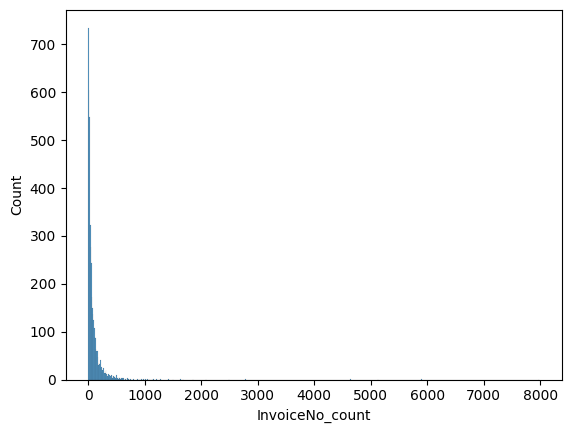

In [13]:
sns.histplot(Customer_data["InvoiceNo_count"])
plt.show()

convert InvoiceNo_count distribution to normal distribution

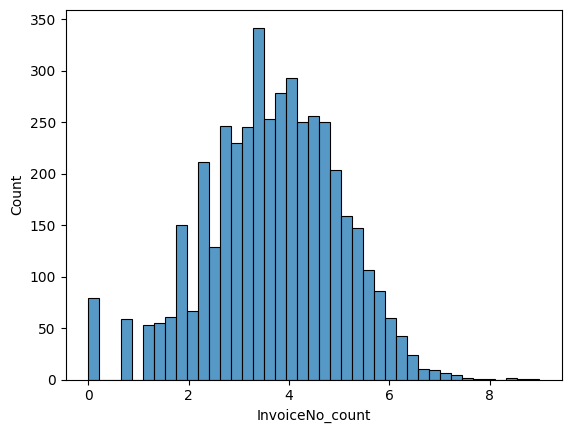

In [14]:
Customer_data["InvoiceNo_count"] = np.log(Customer_data["InvoiceNo_count"])
sns.histplot(Customer_data["InvoiceNo_count"])
plt.show()

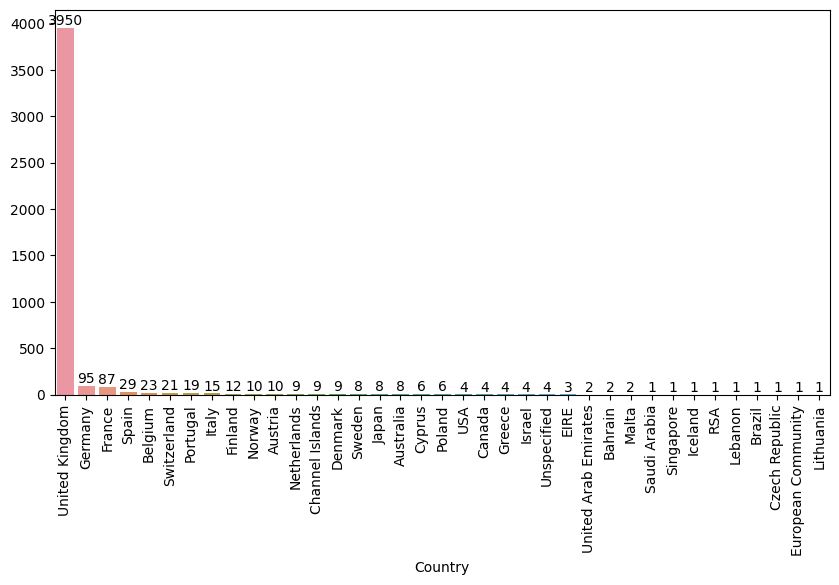

In [15]:
plt.figure(figsize=(10,5))
bar = sns.barplot(x=Customer_data["Country"].value_counts().index, y=Customer_data["Country"].value_counts().to_list())
plt.xticks(rotation=90)

# Add the value labels
bar.bar_label(bar.containers[0])
plt.show()

convert countries with less than 29 occurring to other

In [16]:
Customer_data['Country'] = Customer_data['Country'].apply(lambda x: 'other' if x not in ["United Kingdom", "Germany", "France", "Spain"] else x)

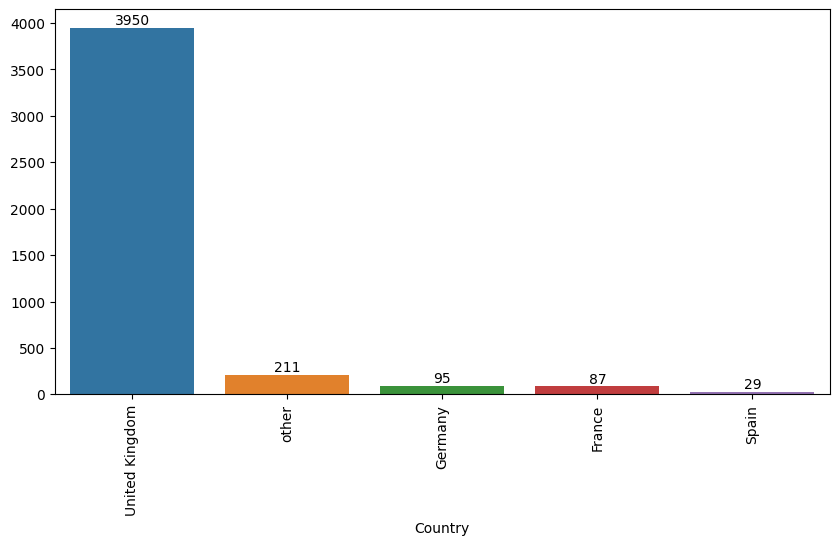

In [17]:
plt.figure(figsize=(10,5))
bar = sns.barplot(x=Customer_data["Country"].value_counts().index, y=Customer_data["Country"].value_counts().to_list())
plt.xticks(rotation=90)

# Add the value labels
bar.bar_label(bar.containers[0])
plt.show()

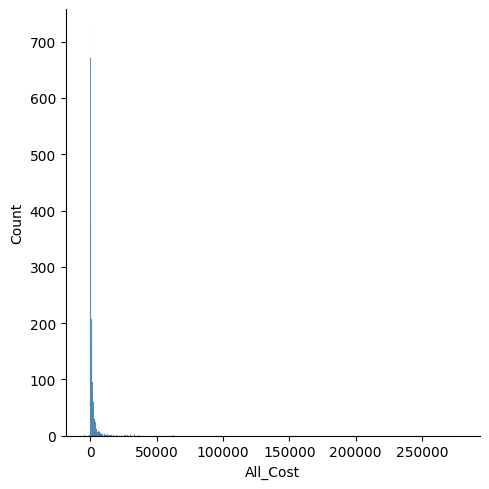

In [18]:
sns.displot(Customer_data["All_Cost"])
plt.show()

remove stopwords and stemming

In [19]:
stemmer = SnowballStemmer(language='english')

for r in Customer_data.iterrows():
    desc = Customer_data.loc[r[0],"All_Description"]
    tokenized = word_tokenize(desc)
    tokenized_filtered = [w for w in tokenized if not w in stopwords.words('english')]
    tokenized_filtered_stemmed = [stemmer.stem(w) for w in tokenized_filtered]
    Customer_data.loc[r[0]]["All_Description"] = " ".join(tokenized_filtered_stemmed)
    

In [20]:
Customer_data = Customer_data.reset_index()
Customer_data.drop("CustomerID", axis=1, inplace=True)
Customer_data

,All_Cost,All_Description,Country,InvoiceNo_count
0,0.00,TOP STORAGE JAR CERAMIC MEDIUM,United Kingdom,0.693147
1,4310.00,HEART SPACEBOY GIRL CLEAR KEEP GLASS. BLUE TEA...,other,5.204007
2,1797.24,HEART HEARTS GIRL WOODLAND SUKI DOUGHNUT STICK...,other,3.433987
3,1757.55,HEART HEARTS RETRO DOUGHNUT CABINET 4 GLASS OW...,other,4.290459
4,334.40,RETRO ELEPHANT SPACEBOY METAL CALCULATOR RETRO...,other,2.833213
...,...,...,...,...
4367,180.60,CHOICE CADDY RACK RETROSPOT CAMEMBERT EMPIRE B...,United Kingdom,2.302585
4368,80.82,SPACEBOY GIRL RACK ROBOT PENNY PARADE GUMBALL ...,United Kingdom,1.945910
4369,176.60,COLOUR LARGE GREEN SPOTS PINK 12 CUTLERY BREAD...,United Kingdom,2.564949
4370,2094.88,LEAVE 4 GLASS PENNY SLATE LIVINGROOM PENCIL AN...,United Kingdom,6.628041


convert (All_Cost) to 4 categories

In [21]:
All_Cost_labels = range(1,5)
All_Cost_group = pd.qcut(Customer_data["All_Cost"], q=4, labels=All_Cost_labels)
Customer_data["All_Cost_group"] = All_Cost_group
Customer_data.drop("All_Cost", axis=1, inplace=True)

encode country

In [23]:
le = LabelEncoder()
Customer_data["Country"] = le.fit_transform(Customer_data["Country"])

clean unmeaning words like word with number and numbers

In [25]:
def text_cleaner(input_str):
    import re

    # Regex pattern to match string with integer
    pattern1 = r'\w+\d+'

    # Regex pattern to match integers
    pattern2 = r'\d+'

    # matches1 = re.findall(pattern1, input_str)

    # # Find all integer matches
    # matches2 = re.findall(pattern2, input_str)

    output_str1 = re.sub(pattern1, '', input_str)

    output_str2 = re.sub(pattern2, '', output_str1)

    return output_str2

In [26]:
Customer_data["All_Description"] = Customer_data["All_Description"].apply(lambda x: text_cleaner(x))

vectorizing words

In [28]:
vectorizer = CountVectorizer(max_features=1000)

vec = vectorizer.fit_transform(Customer_data["All_Description"])

feature_names = vectorizer.get_feature_names_out()

X_array = vec.toarray()

bop = pd.DataFrame(data=X_array ,columns=feature_names)
bop

,abc,acapulco,acrylic,address,advent,aged,aid,airline,airmail,alarm,album,alphabet,aluminium,am,amelie,and,angel,angels,animal,animals,ant,antique,apothecary,apple,apples,apron,area,art,ass,assorted,asstd,babushka,baby,back,backpack,bag,bags,bakelike,baking,ball,balloon,balloons,bank,baroque,baseball,basil,basket,bath,bathroom,baths,bauble,baubles,beach,bead,beaded,beads,beak,beaker,bedroom,bell,belle,bells,bendy,best,beware,bicycle,big,bill,billboard,bin,bingo,bird,birdcage,birdhouse,birds,birdy,birthday,biscuit,biscuits,black,blackboard,block,blocks,blossom,blue,board,bomb,bon,bone,book,books,boom,boot,botanical,botanique,bottle,bottles,bouquet,bowl,bowls,box,boxed,boxes,boy,boys,bracelet,bread,breakfast,brocade,brocante,brown,brush,bubblegum,bucket,buffalo,building,bull,bundle,bunnies,bunny,bunting,bus,butter,butterfly,cabinet,cacti,cafe,cake,cakes,cakestand,calculator,calendar,calm,camouflage,campagne,can,candle,candleholder,candles,candlestick,candy,canvas,caravan,card,cardholder,cards,carriage,carry,cars,cases,cash,cat,catch,cats,ceramic,chain,chalk,chalkboard,charlie,charlotte,charm,charms,chateau,check,cheese,cherry,chest,chic,chick,chicken,chicks,children,childrens,childs,chilli,china,chinese,chives,choc,chocolate,chocolatecandle,choice,chopping,christmas,chrome,cigar,circles,circular,circus,citronella,classic,clay,clear,clips,clock,closed,clothes,cm,coaster,coasters,coat,coathanger,cocktail,coffee,colander,collage,colour,coloured,colouring,colours,come,cones,confectionery,confusing,container,cook,cookie,cooking,cornice,cosy,cottage,cotton,cover,cowboy,cowboys,cracker,crackers,crackle,craft,crate,crates,crayons,cream,crochet,croquet,crossbones,crosses,crystal,cube,cup,cupcake,cupcakes,cupid,cups,curio,cushion,cut,cutlery,cutter,cutters,dairy,daisy,danish,day,de,dec,deco,decoration,decorations,decorative,decoupage,deluxe,des,design,designs,diamante,diet,diner,dinner,dinosaur,dinosaurs,disco,dish,dispenser,diva,dog,doiley,doilies,doily,doll,dolly,dominoes,donkey,door,doormat,doorsign,doorstop,doughnut,dove,drawer,drawers,drawing,dressing,drink,drop,easter,edwardian,egg,eggs,elephant,elixir,embossed,embroidered,emily,empire,enamel,enchanted,england,english,engraved,envelopes,erasers,etched,exercise,fabric,face,fair,fairy,family,fan,fancy,farthing,fashion,fawn,feather,felt,feltcraft,filigree,filigris,filler,fine,finish,first,flag,flags,flannel,flock,flora,floral,flower,flowerpower,flowers,flu,fluted,flying,flytrap,fob,foil,folding,folk,folkart,font,fonts,food,foot,football,for,forest,fork,four,frame,french,fridge,friends,frill,fringe,frog,front,fruit,fruits,frutti,frying,fun,funky,funny,fuschia,game,gaolers,garage,garden,gardeners,gardenia,garland,gazebo,gentlemen,giant,gift,gin,gingerbread,gingham,giraffe,girl,girls,glass,glaze,gliders,glitter,gloss,glove,gloves,gold,goose,grand,green,greeting,grey,grocery,grow,guard,gumball,guns,gymkhana,hairband,hammock,hand,handbag,hanger,hanging,happy,harmonica,heads,heart,hearts,hen,herb,hldr,holder,holders,holiday,holly,home,homemade,honeycomb,hook,hooks,horse,hot,hottie,hour,house,housework,ice,images,in,incense,indians,invites,is,island,it,its,ivory,jack,jam,jar,jardin,jardiniere,jars,jazz,jean,jelly,jet,jewel,jewelled,jewellery,jigsaw,jingle,jubilee,jug,jumbo,junk,keep,keepsake,key,keyrings,keys,kid,kids,kings,kit,kitchen,knack,kneeling,knick,knitted,knitting,knob,la,lace,ladder,ladders,ladies,lamp,lantern,lanterns,large,laundry,lavender,le,leaf,leave,leaves,led,letter,letters,lid,life,light,lights,lip,lipstick,list,little,livingroom,loaf,lola,lolly,london,lounge,love,lovebird,lovebirds,ludo,luggage,lunch,ma,magazine,magic,magnet,magnetic,magnets,maid,mail,make,makers,making,man,manual,marbles,marker,market,marshmallows,mat,matches,me,measuring,medium,memo,memoboard,merry,message,metal,meter,mice,milk,mini,miniature,mint,mirror,mirrored,mistletoe,mitt,mix,mobile,modelling,modern,molly,money,monsoon,monsters,moody,morris,motorbike,motoring,mould,moulds,mouse,mug,multi,multicolour

scaling ["Country", 'InvoiceNo_count', "All_Cost_group"] columns

In [29]:
scaler = StandardScaler()
scale = scaler.fit_transform(Customer_data[["Country", 'InvoiceNo_count', "All_Cost_group"]])

Customer_data[["Country", 'InvoiceNo_count', "All_Cost_group"]] = scale

concatenate Customer_data and bop

In [ ]:
Customer_data.drop(columns="All_Description", axis=1, inplace=True)

In [35]:
final_data = pd.concat([Customer_data, bop], axis=1)
final_data

,Country,InvoiceNo_count,All_Cost_group,abc,acapulco,acrylic,address,advent,aged,aid,airline,airmail,alarm,album,alphabet,aluminium,am,amelie,and,angel,angels,animal,animals,ant,antique,apothecary,apple,apples,apron,area,art,ass,assorted,asstd,babushka,baby,back,backpack,bag,bags,bakelike,baking,ball,balloon,balloons,bank,baroque,baseball,basil,basket,bath,bathroom,baths,bauble,baubles,beach,bead,beaded,beads,beak,beaker,bedroom,bell,belle,bells,bendy,best,beware,bicycle,big,bill,billboard,bin,bingo,bird,birdcage,birdhouse,birds,birdy,birthday,biscuit,biscuits,black,blackboard,block,blocks,blossom,blue,board,bomb,bon,bone,book,books,boom,boot,botanical,botanique,bottle,bottles,bouquet,bowl,bowls,box,boxed,boxes,boy,boys,bracelet,bread,breakfast,brocade,brocante,brown,brush,bubblegum,bucket,buffalo,building,bull,bundle,bunnies,bunny,bunting,bus,butter,butterfly,cabinet,cacti,cafe,cake,cakes,cakestand,calculator,calendar,calm,camouflage,campagne,can,candle,candleholder,candles,candlestick,candy,canvas,caravan,card,cardholder,cards,carriage,carry,cars,cases,cash,cat,catch,cats,ceramic,chain,chalk,chalkboard,charlie,charlotte,charm,charms,chateau,check,cheese,cherry,chest,chic,chick,chicken,chicks,children,childrens,childs,chilli,china,chinese,chives,choc,chocolate,chocolatecandle,choice,chopping,christmas,chrome,cigar,circles,circular,circus,citronella,classic,clay,clear,clips,clock,closed,clothes,cm,coaster,coasters,coat,coathanger,cocktail,coffee,colander,collage,colour,coloured,colouring,colours,come,cones,confectionery,confusing,container,cook,cookie,cooking,cornice,cosy,cottage,cotton,cover,cowboy,cowboys,cracker,crackers,crackle,craft,crate,crates,crayons,cream,crochet,croquet,crossbones,crosses,crystal,cube,cup,cupcake,cupcakes,cupid,cups,curio,cushion,cut,cutlery,cutter,cutters,dairy,daisy,danish,day,de,dec,deco,decoration,decorations,decorative,decoupage,deluxe,des,design,designs,diamante,diet,diner,dinner,dinosaur,dinosaurs,disco,dish,dispenser,diva,dog,doiley,doilies,doily,doll,dolly,dominoes,donkey,door,doormat,doorsign,doorstop,doughnut,dove,drawer,drawers,drawing,dressing,drink,drop,easter,edwardian,egg,eggs,elephant,elixir,embossed,embroidered,emily,empire,enamel,enchanted,england,english,engraved,envelopes,erasers,etched,exercise,fabric,face,fair,fairy,family,fan,fancy,farthing,fashion,fawn,feather,felt,feltcraft,filigree,filigris,filler,fine,finish,first,flag,flags,flannel,flock,flora,floral,flower,flowerpower,flowers,flu,fluted,flying,flytrap,fob,foil,folding,folk,folkart,font,fonts,food,foot,football,for,forest,fork,four,frame,french,fridge,friends,frill,fringe,frog,front,fruit,fruits,frutti,frying,fun,funky,funny,fuschia,game,gaolers,garage,garden,gardeners,gardenia,garland,gazebo,gentlemen,giant,gift,gin,gingerbread,gingham,giraffe,girl,girls,glass,glaze,gliders,glitter,gloss,glove,gloves,gold,goose,grand,green,greeting,grey,grocery,grow,guard,gumball,guns,gymkhana,hairband,hammock,hand,handbag,hanger,hanging,happy,harmonica,heads,heart,hearts,hen,herb,hldr,holder,holders,holiday,holly,home,homemade,honeycomb,hook,hooks,horse,hot,hottie,hour,house,housework,ice,images,in,incense,indians,invites,is,island,it,its,ivory,jack,jam,jar,jardin,jardiniere,jars,jazz,jean,jelly,jet,jewel,jewelled,jewellery,jigsaw,jingle,jubilee,jug,jumbo,junk,keep,keepsake,key,keyrings,keys,kid,kids,kings,kit,kitchen,knack,kneeling,knick,knitted,knitting,knob,la,lace,ladder,ladders,ladies,lamp,lantern,lanterns,large,laundry,lavender,le,leaf,leave,leaves,led,letter,letters,lid,life,light,lights,lip,lipstick,list,little,livingroom,loaf,lola,lolly,london,lounge,love,lovebird,lovebirds,ludo,luggage,lunch,ma,magazine,magic,magnet,magnetic,magnets,maid,mail,make,makers,making,man,manual,marbles,marker,market,marshmallows,mat,matches,me,measuring,medium,memo,memoboard,merry,message,metal,meter,mice,milk,mini,miniature,mint,mirror,mirrored,mistletoe,mitt,mix,mobile,modelling,modern,molly,money,monsoon,monsters,moody,morris,motorbike,motoring,m

DBSCAN:  
this Data is not well-suited for DBSCAN:   
because data is too sparse or has varying densities.  
changing epsilon and minimum samples have no effect on result.

In [36]:
X = final_data.values
dbscan = DBSCAN(eps=0.1, min_samples=300)
dbscan.fit(X)
np.unique(dbscan.labels_)

array([-1], dtype=int64)

K-means:  
find best k for kmeans with elbow method

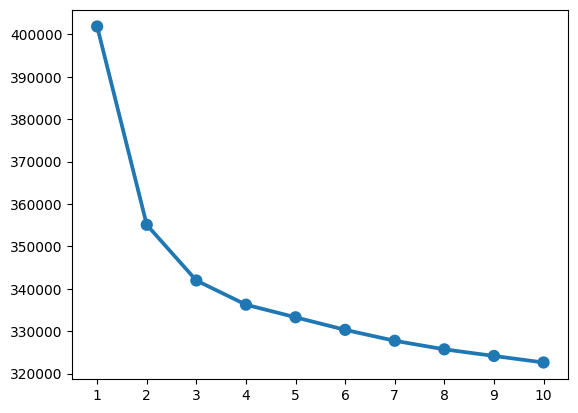

In [37]:
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300)
    kmeans.fit(X)
    wcss[k] = kmeans.inertia_

sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [38]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [39]:
final_data["kmeans.labels"] = kmeans.labels_
y = final_data["kmeans.labels"]

In [52]:
final_data

,Country,InvoiceNo_count,All_Cost_group,abc,acapulco,acrylic,address,advent,aged,aid,airline,airmail,alarm,album,alphabet,aluminium,am,amelie,and,angel,angels,animal,animals,ant,antique,apothecary,apple,apples,apron,area,art,ass,assorted,asstd,babushka,baby,back,backpack,bag,bags,bakelike,baking,ball,balloon,balloons,bank,baroque,baseball,basil,basket,bath,bathroom,baths,bauble,baubles,beach,bead,beaded,beads,beak,beaker,bedroom,bell,belle,bells,bendy,best,beware,bicycle,big,bill,billboard,bin,bingo,bird,birdcage,birdhouse,birds,birdy,birthday,biscuit,biscuits,black,blackboard,block,blocks,blossom,blue,board,bomb,bon,bone,book,books,boom,boot,botanical,botanique,bottle,bottles,bouquet,bowl,bowls,box,boxed,boxes,boy,boys,bracelet,bread,breakfast,brocade,brocante,brown,brush,bubblegum,bucket,buffalo,building,bull,bundle,bunnies,bunny,bunting,bus,butter,butterfly,cabinet,cacti,cafe,cake,cakes,cakestand,calculator,calendar,calm,camouflage,campagne,can,candle,candleholder,candles,candlestick,candy,canvas,caravan,card,cardholder,cards,carriage,carry,cars,cases,cash,cat,catch,cats,ceramic,chain,chalk,chalkboard,charlie,charlotte,charm,charms,chateau,check,cheese,cherry,chest,chic,chick,chicken,chicks,children,childrens,childs,chilli,china,chinese,chives,choc,chocolate,chocolatecandle,choice,chopping,christmas,chrome,cigar,circles,circular,circus,citronella,classic,clay,clear,clips,clock,closed,clothes,cm,coaster,coasters,coat,coathanger,cocktail,coffee,colander,collage,colour,coloured,colouring,colours,come,cones,confectionery,confusing,container,cook,cookie,cooking,cornice,cosy,cottage,cotton,cover,cowboy,cowboys,cracker,crackers,crackle,craft,crate,crates,crayons,cream,crochet,croquet,crossbones,crosses,crystal,cube,cup,cupcake,cupcakes,cupid,cups,curio,cushion,cut,cutlery,cutter,cutters,dairy,daisy,danish,day,de,dec,deco,decoration,decorations,decorative,decoupage,deluxe,des,design,designs,diamante,diet,diner,dinner,dinosaur,dinosaurs,disco,dish,dispenser,diva,dog,doiley,doilies,doily,doll,dolly,dominoes,donkey,door,doormat,doorsign,doorstop,doughnut,dove,drawer,drawers,drawing,dressing,drink,drop,easter,edwardian,egg,eggs,elephant,elixir,embossed,embroidered,emily,empire,enamel,enchanted,england,english,engraved,envelopes,erasers,etched,exercise,fabric,face,fair,fairy,family,fan,fancy,farthing,fashion,fawn,feather,felt,feltcraft,filigree,filigris,filler,fine,finish,first,flag,flags,flannel,flock,flora,floral,flower,flowerpower,flowers,flu,fluted,flying,flytrap,fob,foil,folding,folk,folkart,font,fonts,food,foot,football,for,forest,fork,four,frame,french,fridge,friends,frill,fringe,frog,front,fruit,fruits,frutti,frying,fun,funky,funny,fuschia,game,gaolers,garage,garden,gardeners,gardenia,garland,gazebo,gentlemen,giant,gift,gin,gingerbread,gingham,giraffe,girl,girls,glass,glaze,gliders,glitter,gloss,glove,gloves,gold,goose,grand,green,greeting,grey,grocery,grow,guard,gumball,guns,gymkhana,hairband,hammock,hand,handbag,hanger,hanging,happy,harmonica,heads,heart,hearts,hen,herb,hldr,holder,holders,holiday,holly,home,homemade,honeycomb,hook,hooks,horse,hot,hottie,hour,house,housework,ice,images,in,incense,indians,invites,is,island,it,its,ivory,jack,jam,jar,jardin,jardiniere,jars,jazz,jean,jelly,jet,jewel,jewelled,jewellery,jigsaw,jingle,jubilee,jug,jumbo,junk,keep,keepsake,key,keyrings,keys,kid,kids,kings,kit,kitchen,knack,kneeling,knick,knitted,knitting,knob,la,lace,ladder,ladders,ladies,lamp,lantern,lanterns,large,laundry,lavender,le,leaf,leave,leaves,led,letter,letters,lid,life,light,lights,lip,lipstick,list,little,livingroom,loaf,lola,lolly,london,lounge,love,lovebird,lovebirds,ludo,luggage,lunch,ma,magazine,magic,magnet,magnetic,magnets,maid,mail,make,makers,making,man,manual,marbles,marker,market,marshmallows,mat,matches,me,measuring,medium,memo,memoboard,merry,message,metal,meter,mice,milk,mini,miniature,mint,mirror,mirrored,mistletoe,mitt,mix,mobile,modelling,modern,molly,money,monsoon,monsters,moody,morris,motorbike,motoring,m

train KNeighborsClassifier for classification

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [43]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

classification report

In [44]:
y_pred = neigh.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       423
           1       1.00      0.31      0.48        70
           2       0.44      0.16      0.23       226
           3       0.07      0.03      0.04       374

    accuracy                           0.45      1093
   macro avg       0.51      0.38      0.36      1093
weighted avg       0.38      0.45      0.36      1093



confusion matrix

In [46]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[423   0   0   0]
 [  0  22  46   2]
 [ 37   0  36 153]
 [362   0   0  12]]


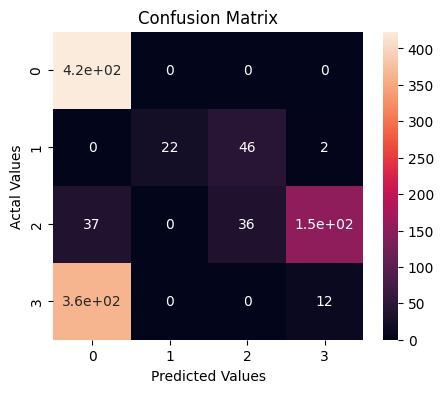

In [47]:
cm_df = pd.DataFrame(cm,
                     index = [0, 1, 2, 3], 
                     columns = [0, 1, 2, 3])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

XGBClassifier

In [48]:
# XGBClassifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_clf.fit(X_train,y_train)

# y_train_preds = xgb.predict(X_train)
y_test_preds = xgb_clf.predict(X_test)
y_train_preds = xgb_clf.predict(X_train)

print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       423
           1       0.91      0.74      0.82        70
           2       0.84      0.88      0.86       226
           3       0.89      0.87      0.88       374

    accuracy                           0.90      1093
   macro avg       0.90      0.86      0.88      1093
weighted avg       0.90      0.90      0.90      1093



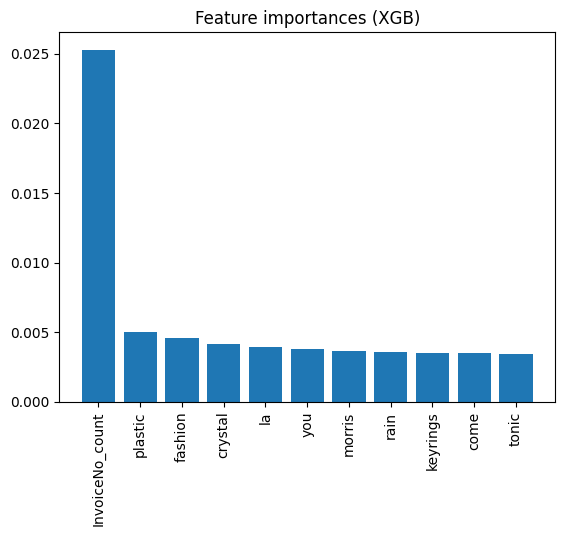

In [49]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(final_data.columns, xgb_clf.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances.loc[:10]))
plt.bar(x_pos, xgb_feature_importances.loc[:10]['score'])
plt.xticks(x_pos, xgb_feature_importances.loc[:10]['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

finding the optimal parameter values with GridSearchCV

In [50]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = XGBClassifier(random_state=100)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.5}
Best score:  0.9219265499906907


In [51]:
# XGBClassifier after gridsearch
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5, colsample_bytree=1, max_depth=7)
xgb_clf.fit(X_train,y_train)

# y_train_preds = xgb.predict(X_train)
y_test_preds = xgb_clf.predict(X_test)
y_train_preds = xgb_clf.predict(X_train)

print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       423
           1       0.95      0.80      0.87        70
           2       0.85      0.89      0.87       226
           3       0.89      0.88      0.88       374

    accuracy                           0.91      1093
   macro avg       0.91      0.88      0.89      1093
weighted avg       0.91      0.91      0.91      1093



For example, in order for the customer to be in category `0`, he must buy at least 5 products

In [74]:
count = 0
for i in final_data.head(1).iloc[:,3:-1]:
    if final_data.head(1)[i][0] == 1:
        count += 1
count

5